In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import pickle
import seaborn as sns
import os

import vdmlab as vdm

In [6]:
def get_summary(decoded, times):
    decode = dict(u=[], shortcut=[], novel=[])
    for key in decoded:
        for session in range(len(times)):
            decode[key].append(len(decoded_1[key][session].time)/times[session])
    return decode

In [23]:
weighted_mean1 = dict(u=1, shortcut=1, novel=1)
weighted_sem1 = dict(u=0.1, shortcut=0.1, novel=0.1)
weighted_mean2 = dict(u=3, shortcut=2, novel=3)
weighted_sem2 = dict(u=0.1, shortcut=0.1, novel=0.1)

means = [weighted_mean1, weighted_mean2, weighted_mean1]
sems = [weighted_sem1, weighted_sem2, weighted_sem1]

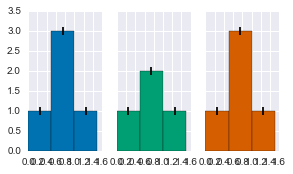

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(4.5, 2.5))

ind = np.arange(1)
width = 0.5
colours = dict(u='#0072b2', shortcut='#009e73', novel='#d55e00')

for ax, trajectory in zip([ax1, ax2, ax3], ['u', 'shortcut', 'novel']):
    count = 0
    for mean, sem in zip(means, sems):
        ax.bar(ind+(count*width), mean[trajectory], width, color=colours[trajectory], 
               yerr=sem[trajectory], ecolor='k')
        count += 1
#     ax.bar(ind, weighted_mean1[trajectory], width,
#            color=colours[trajectory], yerr=weighted_sem1[trajectory], ecolor='k')
#     ax.bar(ind + width, weighted_mean2[trajectory], width,
#            color=colours[trajectory], yerr=weighted_sem2[trajectory], ecolor='k')